# Latent LSTM

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer
from src.utils.initializer import Initializer

from src.models.latent_lstm import LatentLSTM

import numpy as np
import os

%load_ext autoreload
%autoreload 2

TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm')

In [2]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [3]:
IMAGE_SZ = (64, 64)
BATCH_SZ = 32
NUM_WORKERS = 4
MAX_FRAMES = 10
TRANSFORMS = transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])
TRAIN_GIF_PATH = os.path.join(os.getcwd(), 'src/datasets/GGIF/GIFs/nature/train')
VAL_GIF_PATH = os.path.join(os.getcwd(), 'src/datasets/GGIF/GIFs/nature/val')
TEST_GIF_PATH = os.path.join(os.getcwd(), 'src/datasets/GGIF/GIFs/nature/test')

train_set = TGIF(root=TRAIN_GIF_PATH, max_frames=MAX_FRAMES, transform=TRANSFORMS)
val_set = TGIF(root=VAL_GIF_PATH, max_frames=MAX_FRAMES, transform=TRANSFORMS,)
test_set = TGIF(root=TEST_GIF_PATH, max_frames=MAX_FRAMES, transform=TRANSFORMS)

overfit_train_set = DataLoader(train_set, 
                               batch_size=BATCH_SZ, 
                               num_workers=NUM_WORKERS, 
                               drop_last=True,
                               sampler=sampler.SubsetRandomSampler([i for i in range(178, 178 + BATCH_SZ)]))


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set), len(test_set))

3995 748 249


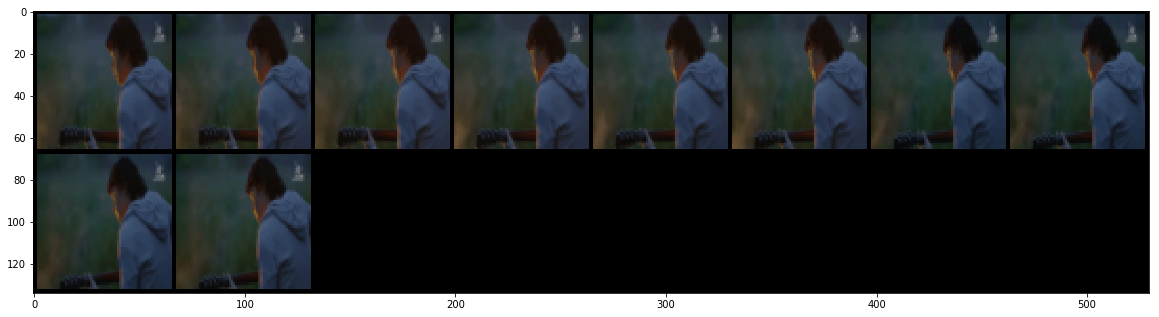

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
gif = dataiter.next()[0]

def imshow(img, save_file=None):
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    if save_file:
        plt.imsave(save_file, out)
    plt.imshow(out)
    
imshow(torchvision.utils.make_grid(gif))

In [5]:
def train_fn(model, optimizer, x):
    def loss_fn(a, b): 
        losses = F.mse_loss(a, b)
        return losses
    
    """
    x is shape N x T x C x H x W
    """
    
    h0 = model.init_hidden(BATCH_SZ)
    model.train()            
        
    x = x.to(device=device, dtype=dtype)

    # x shape: N x T x (C * H * W)
    next_frames, _ = model(x, h0)
    
    # next_frames shape: N x T x (C * H * W)
    loss = loss_fn(next_frames[:, :-1, :], x[:, 1:, :])
    
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [6]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE

model = LatentLSTM(latent_size=1015, device=device)
Initializer.initialize(model=model, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))


BEST_AUTOENCODER_PATH = os.path.join(os.getcwd(), 'src', 'backups', 'ae-tune-imagenet-best', 'experiment_0', 'checkpoints')
ModelTrainer.load_model(checkpoint_path=BEST_AUTOENCODER_PATH, model=model.ae)

In [7]:
def img_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

DISP_LIM = 8
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    img_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0]
    x = x.to(device=device, dtype=dtype)
    y = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    img_show(torchvision.utils.make_grid(imgs))

torch.Size([10, 3, 64, 64])


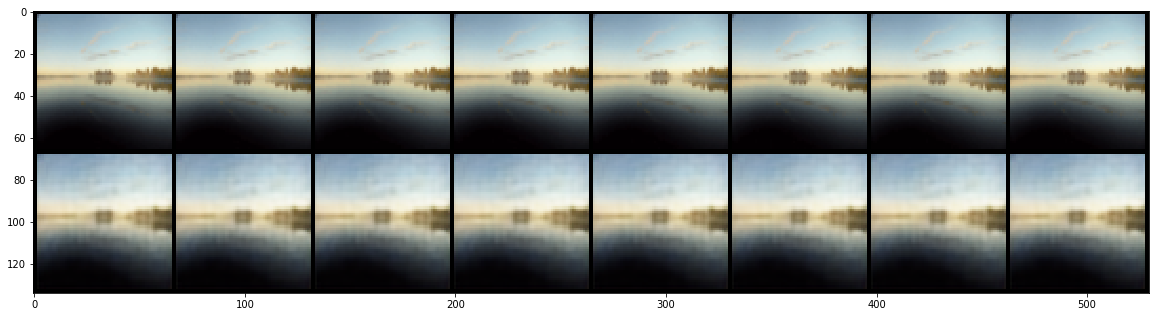

In [8]:
img_test_autoenc(model.ae, train_loader)

In [9]:
LSTM_DEBUG_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm-debug')
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, nesterov=True)
trainer = ModelTrainer(model, optimizer, train_fn, LSTM_DEBUG_ROOT, tags=["lstm", "latent-lstm"])

In [ ]:
trainer.train(train_loader, verbose=True, print_every=20, epochs=10)

Epoch [0] (0/124), loss = 0.2279
Epoch [0] (100/124), loss = 0.0323
Epoch [0] done
Epoch [1] (0/124), loss = 0.0279
Epoch [1] (100/124), loss = 0.0250
Epoch [1] done
Epoch [2] (0/124), loss = 0.0298
Epoch [2] (100/124), loss = 0.0238
Epoch [2] done
Epoch [3] (0/124), loss = 0.0191
Epoch [3] (100/124), loss = 0.0256
Epoch [3] done
Epoch [4] (0/124), loss = 0.0191
Epoch [4] (100/124), loss = 0.0208
Epoch [4] done
Epoch [5] (0/124), loss = 0.0246
Epoch [5] (100/124), loss = 0.0190
Epoch [5] done
Epoch [6] (0/124), loss = 0.0179
Epoch [6] (100/124), loss = 0.0164
Epoch [6] done
Epoch [7] (0/124), loss = 0.0192


In [10]:
%matplotlib inline
from IPython import display
import time


def img_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

def plot_frame_double(index, real, fake):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.subplots_adjust(hspace=0)
    
    real = real.numpy()
    real = np.transpose(real, (1, 2, 0))
    
    fake = fake.numpy()
    fake = np.transpose(fake, (1, 2, 0))
    
    axes[0].imshow(real)
    axes[0].set_title(f'[REAL] Frame #{index + 1}')
    
    axes[1].imshow(fake)
    axes[1].set_title(f'[FAKE] Frame #{index + 1}')
    plt.gcf().show()    

def plot_frame_single(index, frame):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    fig.subplots_adjust(hspace=0)
    npframe = frame.numpy()
    npframe = np.transpose(npframe, (1, 2, 0))
    ax.imshow(npframe)
    ax.set_title(f'FRAME #{index + 1}')
    plt.gcf().show()
    


            
# display.clear_output(wait=False)
# display_loop(10)

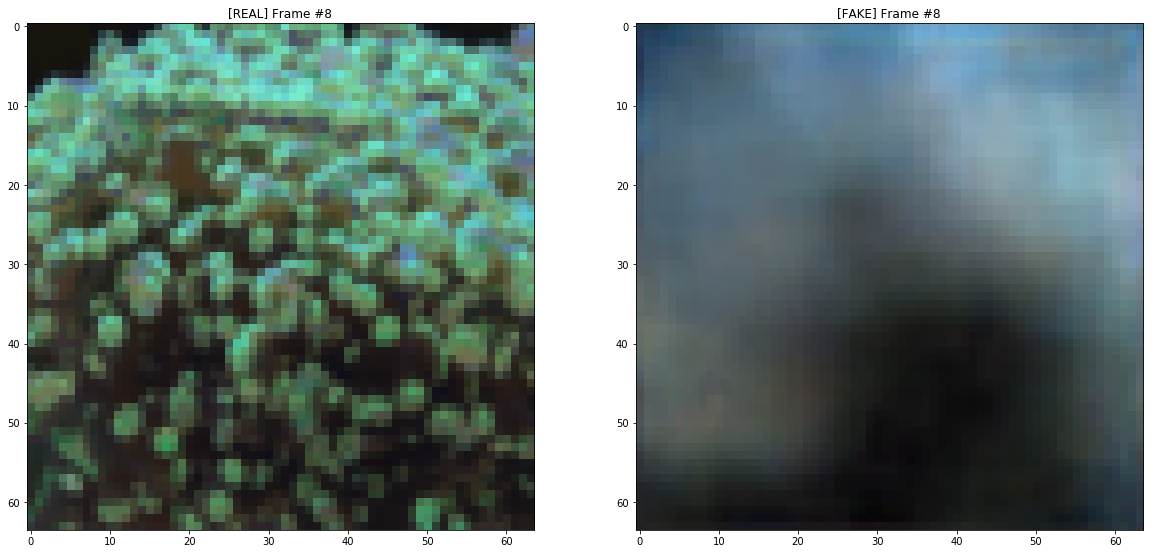

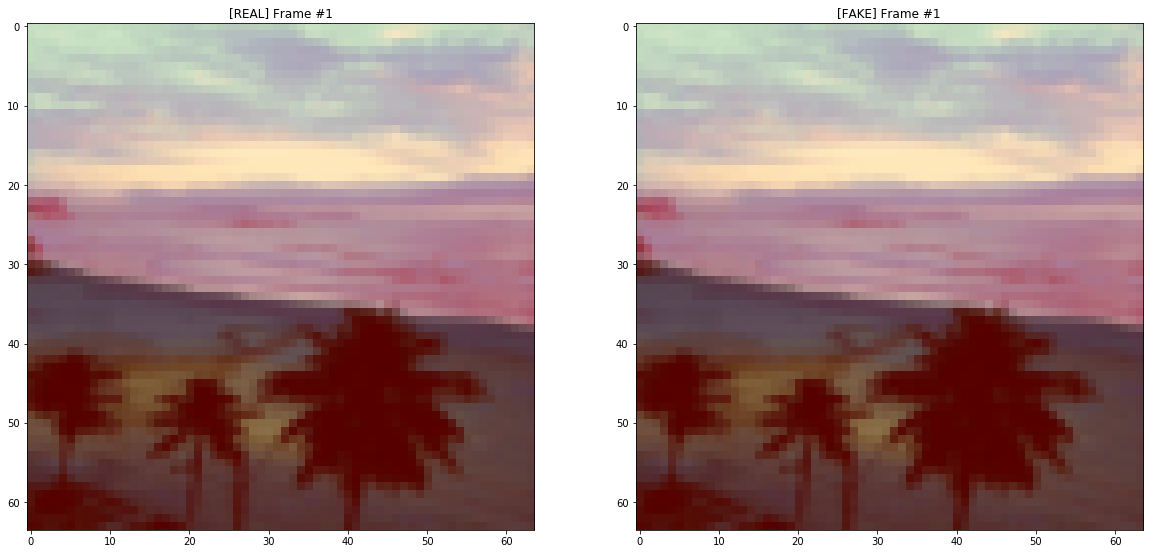

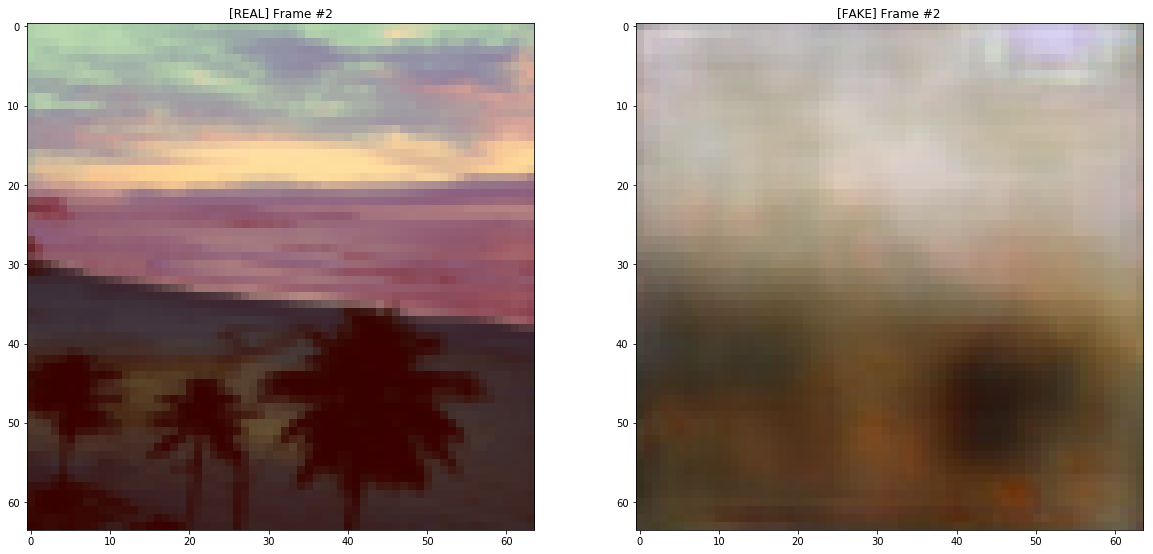

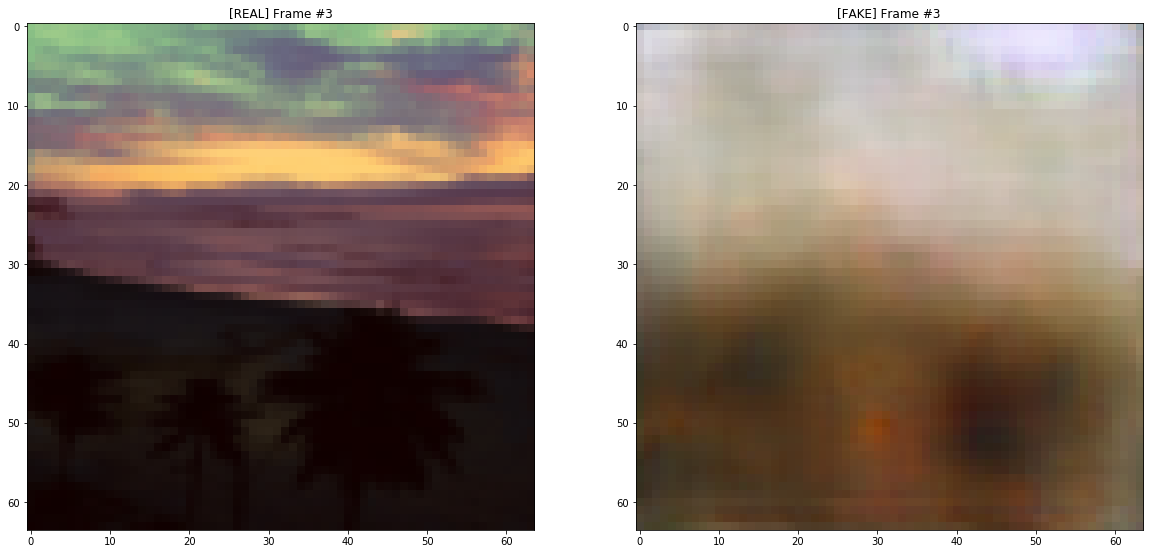

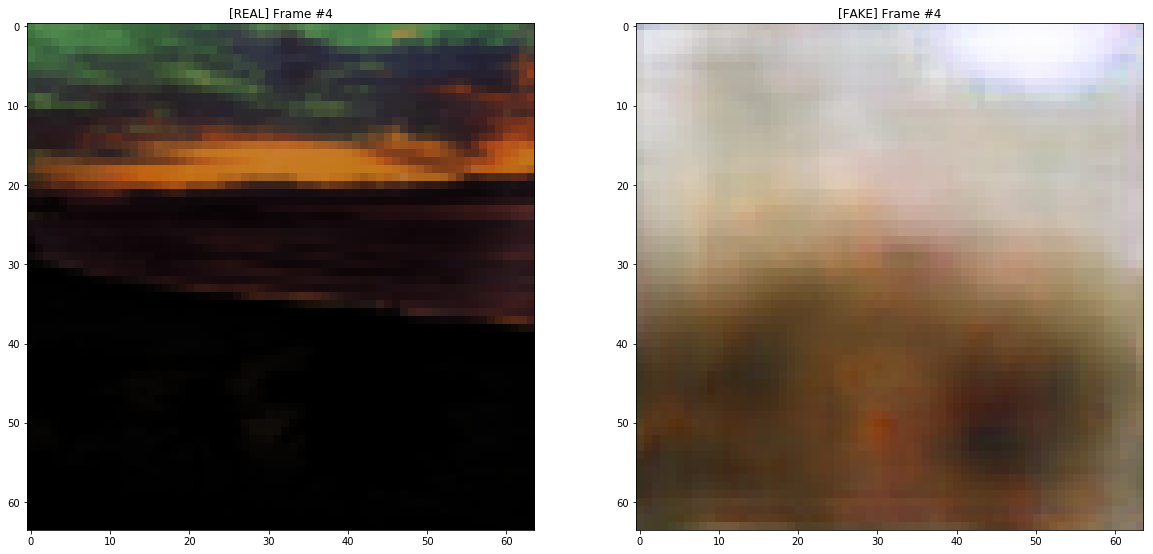

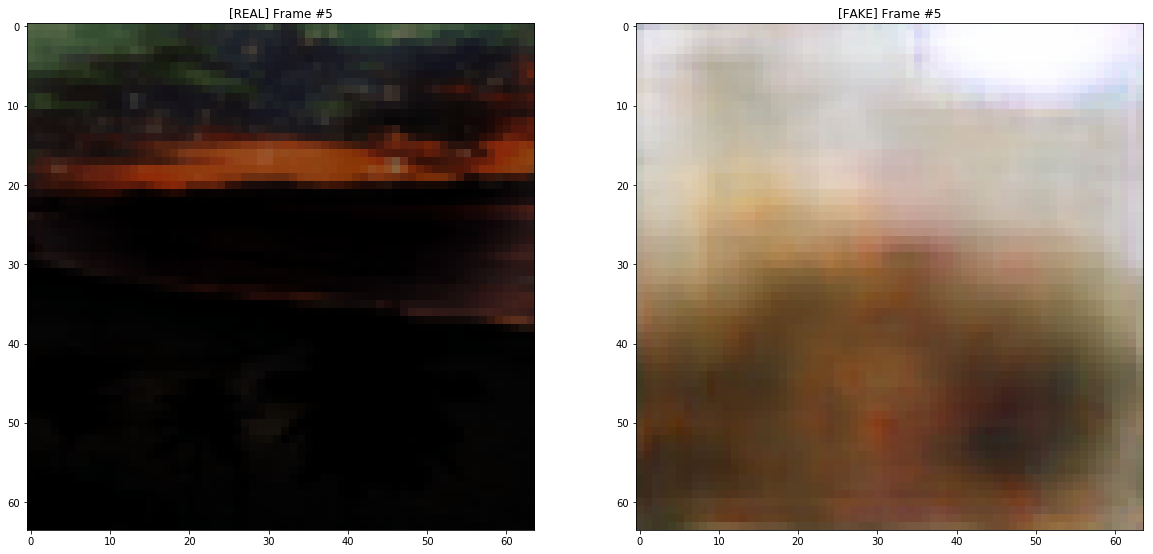

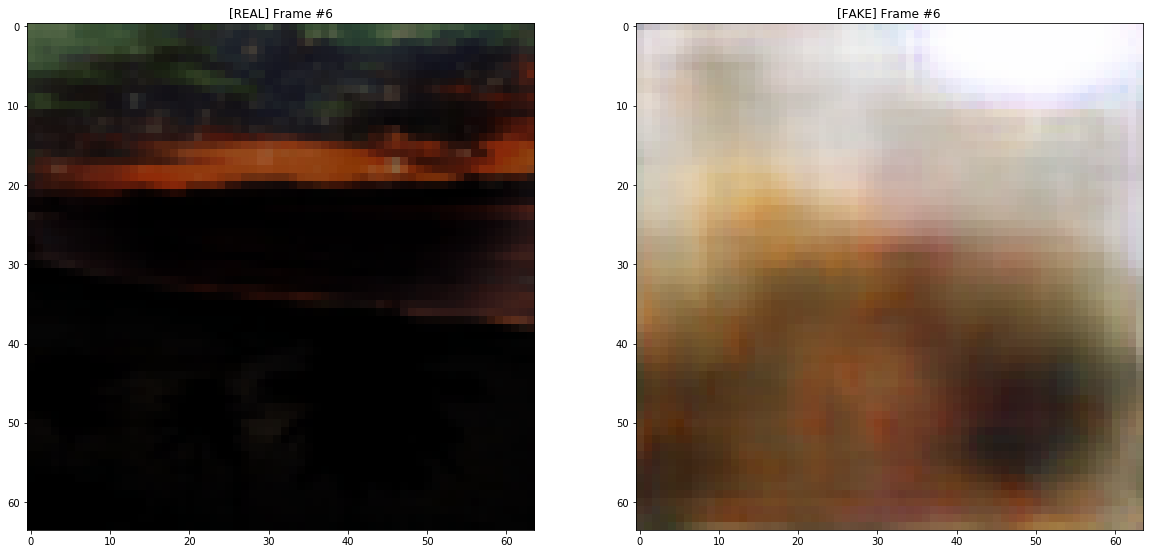

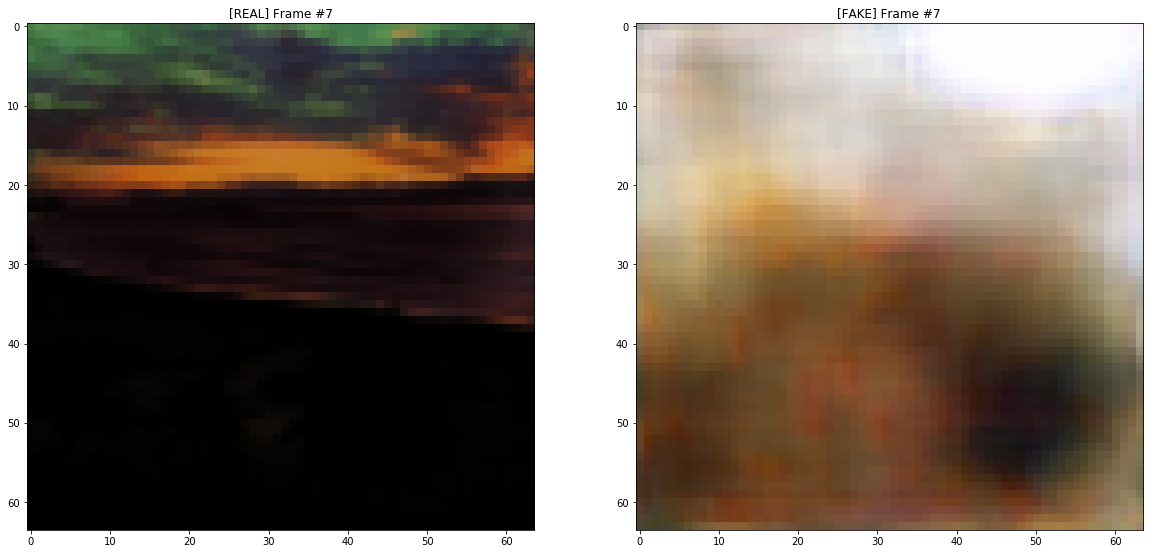

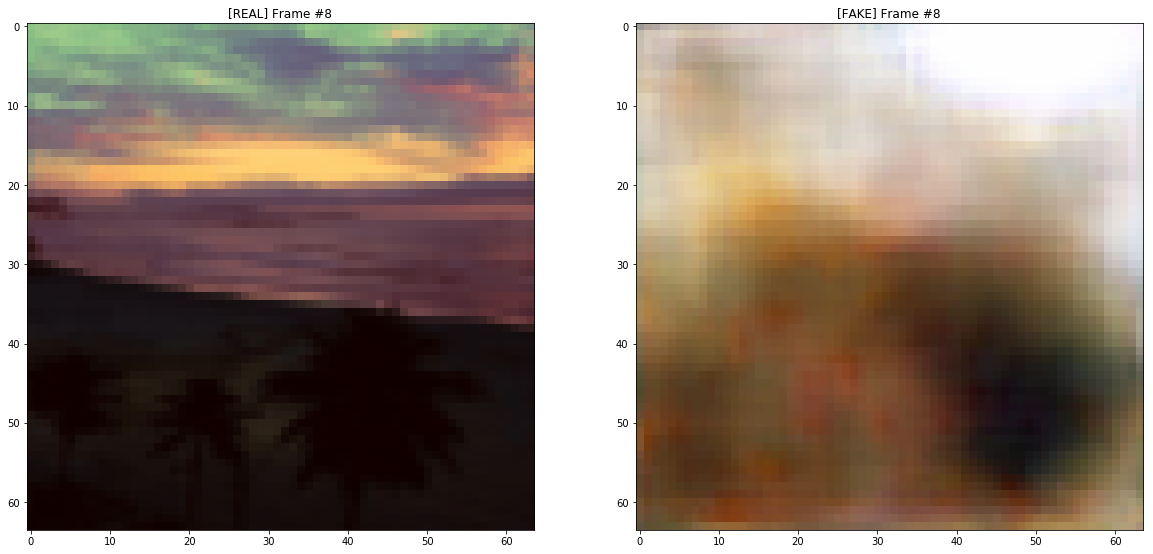

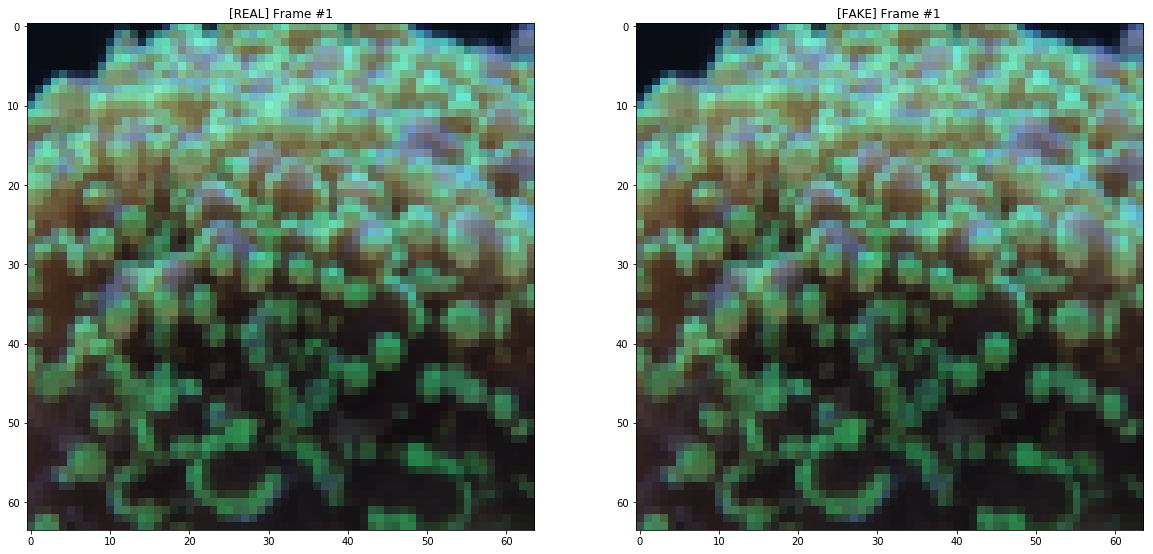

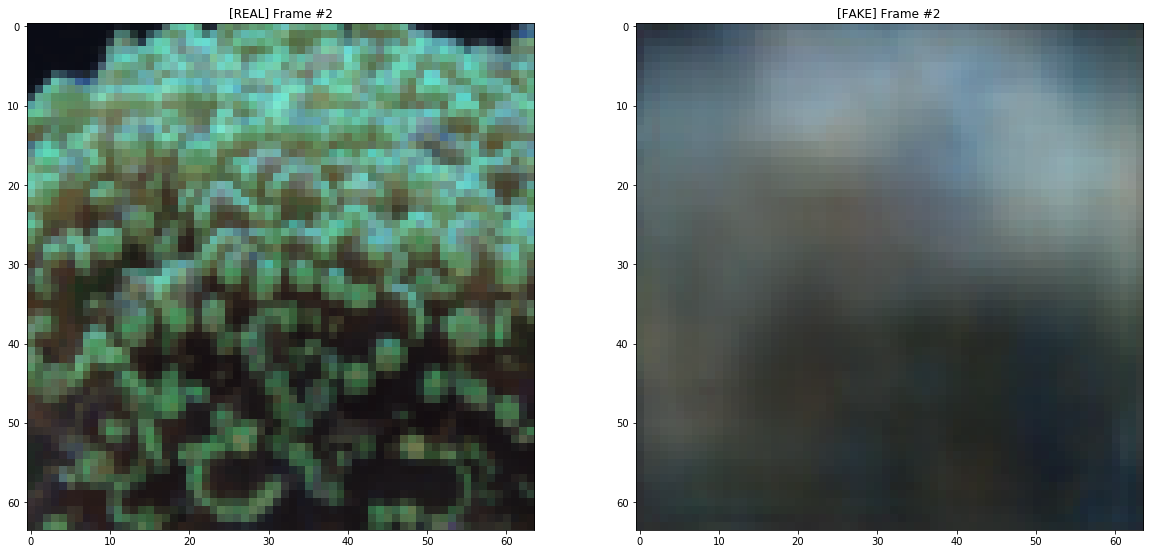

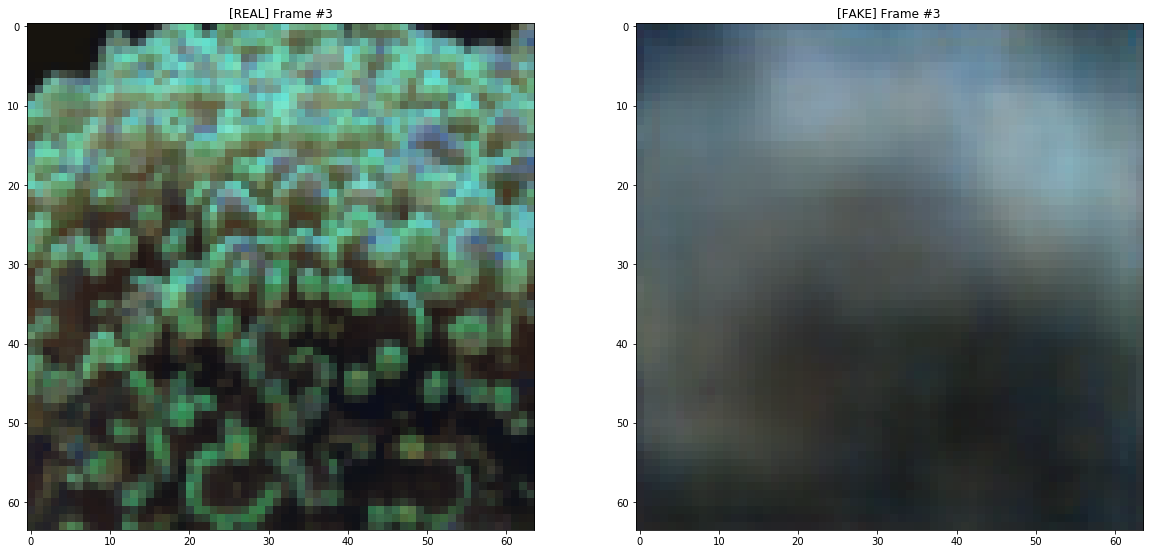

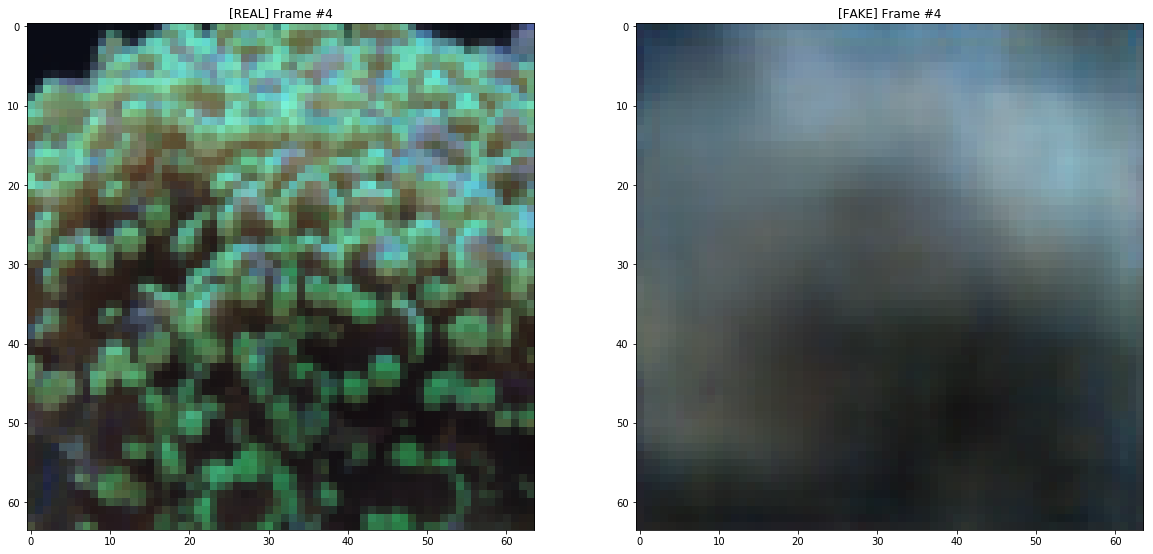

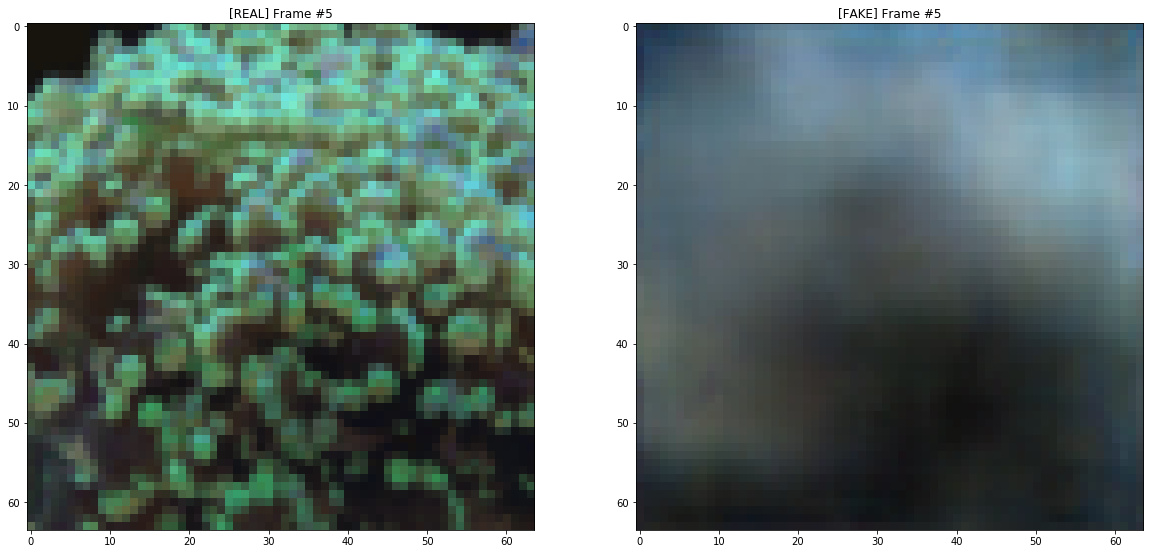

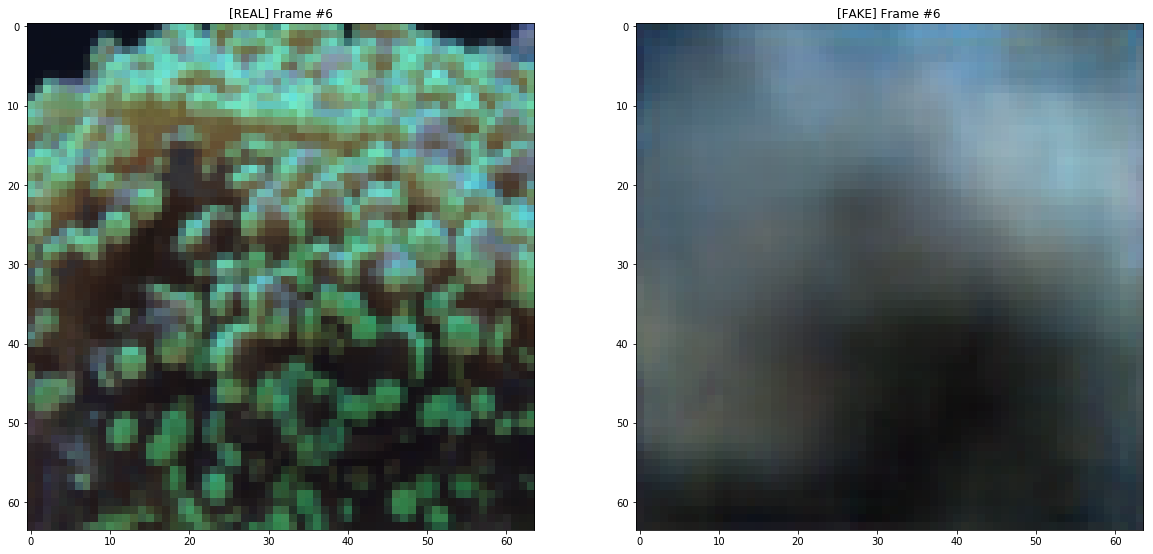

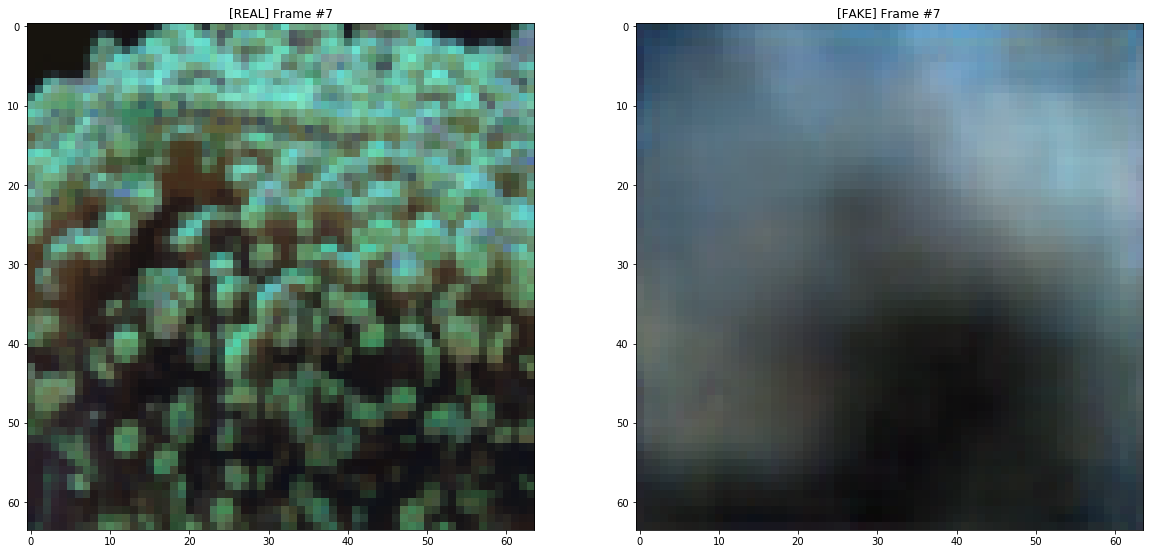

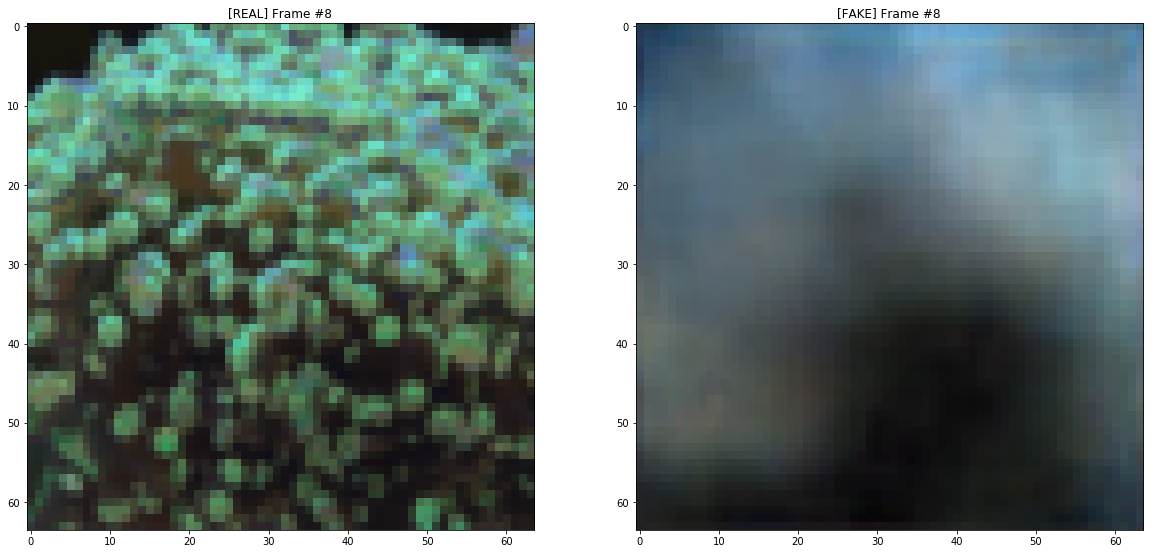

In [72]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def make_gif(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    ret = [seed_frame]
    
    for i in range(gif_length - 1): 
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    
    return torch.stack(ret).transpose(0, 1).squeeze()


def display_loop(gif, generated):
    for index, (frame1, frame2) in enumerate(zip(gif, generated)):
        plot_frame_double(index, frame1, frame2)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.15)

            

def test_lstm(loader):
    model.eval()
    
    dataiter = iter(loader)
    x = dataiter.next()
    
    seeds = x[:, 0, :, :, :]
    seeds = seeds.unsqueeze(1)
    
    gif = make_gif(model, seeds)
#     print(x.shape, gif.shape)
    
    
    orig_gifs = torch.cat(tuple(x))[:8]
    out_gifs = torch.cat(tuple(gif))[:8]
    
    out_gifs = out_gifs.clamp(0, 1)
    
#     imshow(torchvision.utils.make_grid(orig_gifs)) #, save_file='img/train_test_orig.png')
    
#     imshow(torchvision.utils.make_grid(out_gifs.detach())) #, save_file='img/train_test_out.png')

    display_loop(orig_gifs.detach(), out_gifs.detach())

    
test_lstm(train_loader)
test_lstm(val_loader)